In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoLars, LinearRegression, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE

import wrangle
import explore

import warnings
warnings.filterwarnings("ignore")

# Zillow Value Report

### By Brian Manoff

#### Project Goal

The project goal is to Predict home value based on features from the Zillow dataframe.

#### Project Description

Home value and housing estimates are a comtroversial subject. It is important to be able to accurately predict home prices in any given area. The features included in the Zillow data may lead us to create a model that will allow for those, hopefully, accurate predictions.

#### Questions:

How does location effect value?

How does size effect price?

How does home age relate to value?

### Wrangling, cleaning and splitting data

In [2]:
df = wrangle.wrangle_zillow()
df.shape

(49668, 6)

In [3]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,fips,yearbuilt
0,4,2.0,1696,252549,6037,1960
1,3,2.0,1470,512000,6037,1957
2,3,2.0,1450,229856,6037,1957
3,3,2.0,1694,294026,6037,1957
4,4,3.0,2578,426407,6037,1963


In [4]:
df.fips.value_counts()

6037    32966
6059    12334
6111     4368
Name: fips, dtype: int64

In [5]:
train, validate, test = wrangle.train_validate_test_split(df, seed=123) # creating data split

Looking at overall tax value data

346502.8809549491


(array([4141., 4948., 5531., 4551., 3318., 2077., 1424.,  927.,  565.,
         331.]),
 array([   9651. ,  113939.9,  218228.8,  322517.7,  426806.6,  531095.5,
         635384.4,  739673.3,  843962.2,  948251.1, 1052540. ]),
 <BarContainer object of 10 artists>)

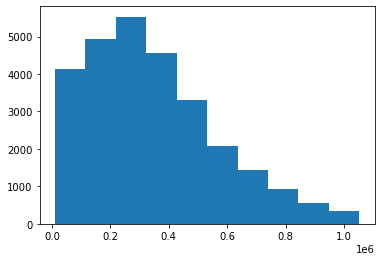

In [6]:
print(train.taxvaluedollarcnt.mean())
plt.hist(train.taxvaluedollarcnt)

Takeaway:

Average value is in the mid 300k's

Looking at value vs features

In [7]:
value = ['taxvaluedollarcnt']
features = ['bathroomcnt', 'bedroomcnt', 'yearbuilt', 'fips', 'calculatedfinishedsquarefeet']

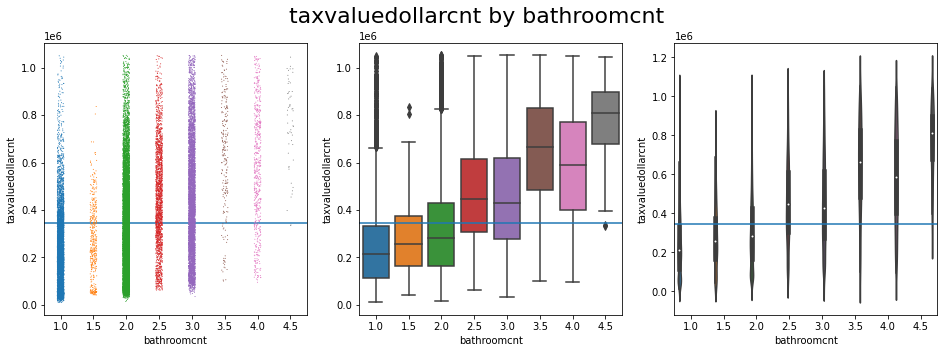

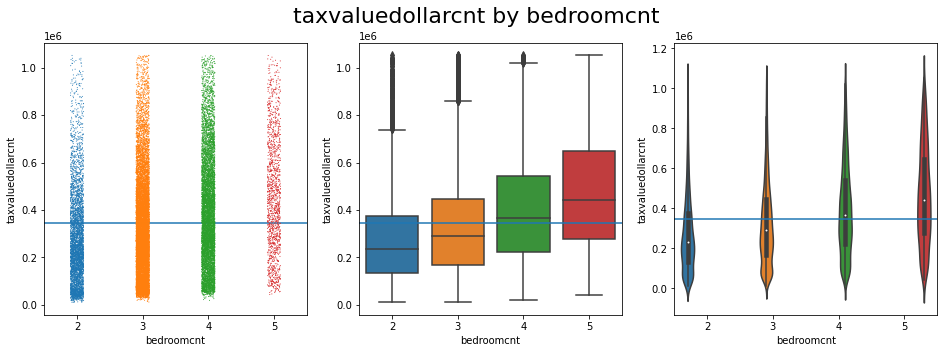

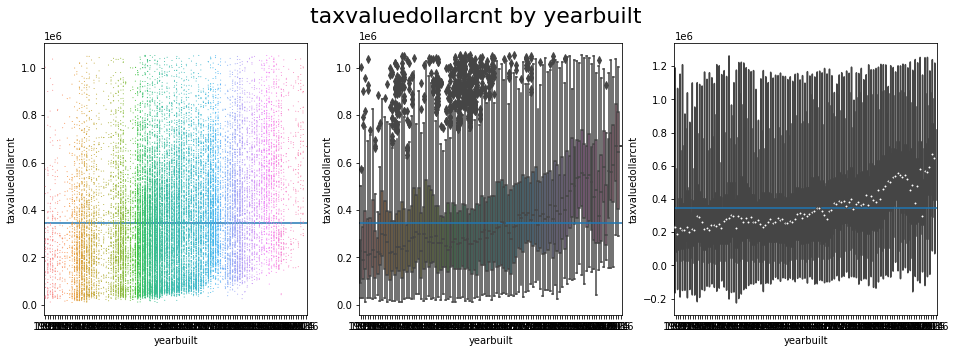

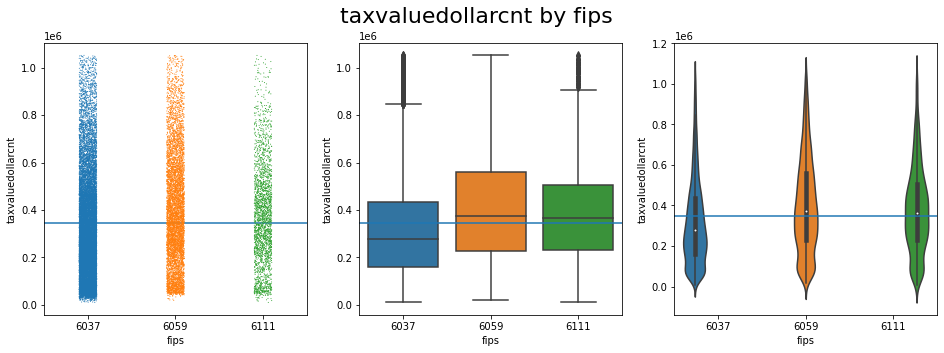

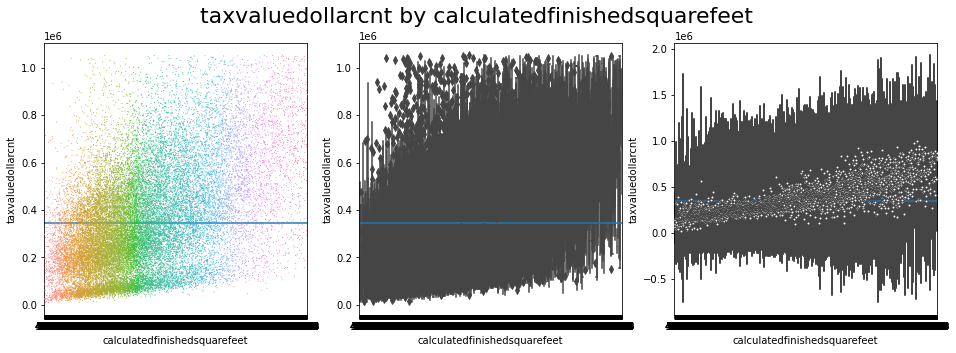

In [8]:
explore.plot_value_features(train, value, features)

Takeaway:

Visually looking at the features, value increases with more bedrooms, bathrooms, square footage and newer homes. It also seems that location has an effect on value as well.


#### Statistical testing:

In [9]:
alpha = 0.5

H0: The feature has no relationship with home value

H1: The feature has some relationship with home value

In [10]:
corr, p = stats.pearsonr(train['taxvaluedollarcnt'], train['calculatedfinishedsquarefeet'])
corr, p

if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.") # Figuring out whether we are accepting or rejecting null

We reject the null hypothesis.


In [11]:
corr, p = stats.pearsonr(train['taxvaluedollarcnt'], train['bedroomcnt'])
corr, p

if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.") # Figuring out whether we are accepting or rejecting null

We reject the null hypothesis.


In [12]:
corr, p = stats.pearsonr(train['taxvaluedollarcnt'], train['bathroomcnt'])
corr, p

if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.") # Figuring out whether we are accepting or rejecting null

We reject the null hypothesis.


In [13]:
corr, p = stats.pearsonr(train['taxvaluedollarcnt'], train['fips'])
corr, p

if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.") # Figuring out whether we are accepting or rejecting null

We reject the null hypothesis.


In [14]:
corr, p = stats.pearsonr(train['taxvaluedollarcnt'], train['yearbuilt'])
corr, p

if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.") # Figuring out whether we are accepting or rejecting null

We reject the null hypothesis.


All of the features are statistically significantly related to price as well.

Scaling data for modeling.

In [15]:
train_scaled, validate_scaled, test_scaled = wrangle.scale_data(train, validate, test, ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt'])

In [16]:
train_scaled.head() # looking at new scaled features

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,fips,yearbuilt,bedroomcnt_scaled,bathroomcnt_scaled,calculatedfinishedsquarefeet_scaled,yearbuilt_scaled
45421,5,3.0,2918,165180,6037,1972,1.000000,0.571429,0.769085,0.588785
50665,3,2.0,1357,304584,6037,1957,0.333333,0.285714,0.276656,0.448598
30944,3,2.5,1887,551720,6059,1987,0.333333,0.428571,0.443849,0.728972
6662,3,2.0,1457,323000,6037,1979,0.333333,0.285714,0.308202,0.654206
50654,2,2.0,1067,47377,6037,1951,0.000000,0.285714,0.185174,0.392523


Setting x to scaled data and y to the unscaled variable.

In [17]:
X_train_original = train[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt', 'fips']] # Unscaled features
X_train = train_scaled[['bedroomcnt_scaled', 'bathroomcnt_scaled', 'calculatedfinishedsquarefeet_scaled']] # scaled features
y_train = train['taxvaluedollarcnt'] # Unscaled, target variable only

X_validate = validate_scaled[['bedroomcnt_scaled', 'bathroomcnt_scaled', 'calculatedfinishedsquarefeet_scaled']] # scaled features
y_validate= validate['taxvaluedollarcnt'] # Unscaled, target variable only

X_test= test_scaled[['bedroomcnt_scaled', 'bathroomcnt_scaled', 'calculatedfinishedsquarefeet_scaled']] # scaled features
y_test = test['taxvaluedollarcnt'] # Unscaled, target variable only

Setting up predictions

In [18]:
# Make these dataframes to allow for baselines to be appended
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# Predict mean
value_pred_mean = y_train['taxvaluedollarcnt'].mean()
y_train['value_pred_mean'] = value_pred_mean
y_validate['value_pred_mean'] = value_pred_mean

# Predict median
value_pred_median = y_train['taxvaluedollarcnt'].median()
y_train['value_pred_median'] = value_pred_median
y_validate['value_pred_median'] = value_pred_median

In [19]:
y_train.head()

,taxvaluedollarcnt,value_pred_mean,value_pred_median
45421,165180,346502.880955,307594.0
50665,304584,346502.880955,307594.0
30944,551720,346502.880955,307594.0
6662,323000,346502.880955,307594.0
50654,47377,346502.880955,307594.0


Setting the baseline RMSE off of predictions.

In [20]:
  # RMSE mean
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.value_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# median
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.value_pred_median)**(1/2)


RMSE using Mean
Train/In-Sample:  220002.62 
Validate/Out-of-Sample:  218986.18


Creating and evalutating regression models based on RMSE

In [21]:
# LinearRegression (OLS)

# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['taxvaluedollarcnt_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvaluedollarcnt_pred_lm)**(1/2)

# predict validate
y_validate['taxvaluedollarcnt_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  192189.9368412808 
Validation/Out-of-Sample:  192641.71485542526


In [22]:
# Lasso lars

# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['taxvaluedollarcnt_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvaluedollarcnt_pred_lars)**(1/2)

# predict validate
y_validate['taxvaluedollarcnt_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  192190.34770394064 
Validation/Out-of-Sample:  192646.62341748903


In [23]:
# Tweedie regressor

# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['taxvaluedollarcnt_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvaluedollarcnt_pred_glm)**(1/2)

# predict validate
y_validate['taxvaluedollarcnt_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  192601.97454793093 
Validation/Out-of-Sample:  193055.50231749585


In [24]:
# polynomial features

# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

# polynomial linear regression

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.taxvaluedollarcnt)

# predict train
y_train['taxvaluedollarcnt_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvaluedollarcnt_pred_lm2)**(1/2)

# predict validate
y_validate['taxvaluedollarcnt_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  192046.35860342218 
Validation/Out-of-Sample:  192431.36973713842


Top model visuals and selection

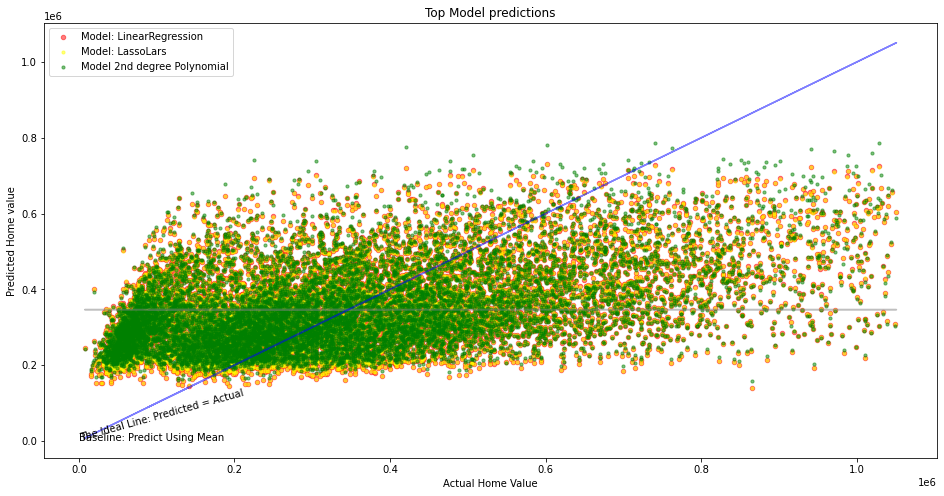

In [25]:
plt.figure(figsize=(16,8))
plt.plot(y_validate.taxvaluedollarcnt, y_validate.value_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_lm, 
            alpha=.5, color="red", s=20, label="Model: LinearRegression")
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_lars, 
            alpha=.5, color="yellow", s=10, label="Model: LassoLars")
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_lm2, 
            alpha=.5, color="green", s=10, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Home Value")
plt.ylabel("Predicted Home value")
plt.title("Top Model predictions")
plt.show()

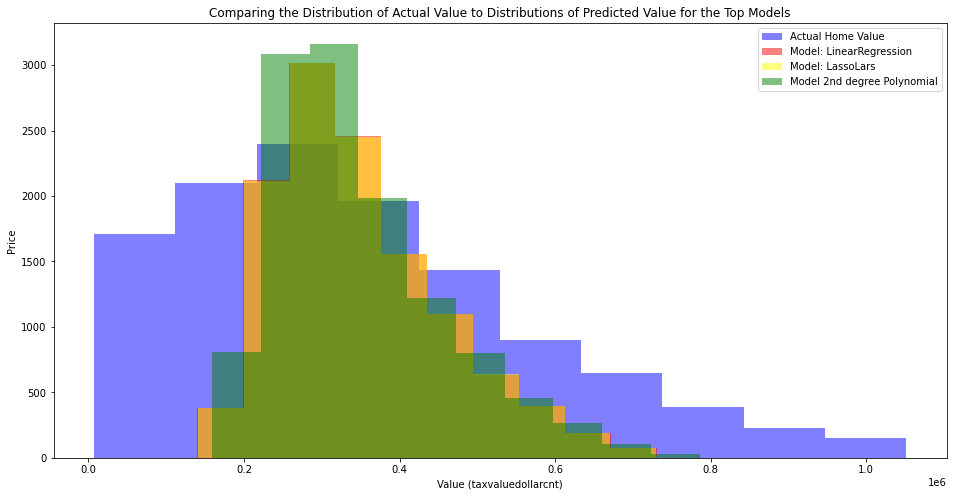

In [26]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.taxvaluedollarcnt, color='blue', alpha=.5, label="Actual Home Value")
plt.hist(y_validate.taxvaluedollarcnt_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.taxvaluedollarcnt_pred_lars, color='yellow', alpha=.5, label="Model: LassoLars")
plt.hist(y_validate.taxvaluedollarcnt_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Value (taxvaluedollarcnt)")
plt.ylabel("Price")
plt.title("Comparing the Distribution of Actual Value to Distributions of Predicted Value for the Top Models")
plt.legend()
plt.show()

I've chosen the 2nd degree Polynomial model, as it performed the best according to RMSE

In [27]:
#turn the y_test into a dataframe
y_test = pd.DataFrame(y_test)

# predict on test
y_test['taxvaluedollarcnt_pred_lm2'] = lm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.taxvaluedollarcnt, y_test.taxvaluedollarcnt_pred_lm2)**(1/2)

print("RMSE for OLS Model using 2nd degree Polynomial\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using 2nd degree Polynomial
Out-of-Sample Performance:  193792.06477952693


#### Key Findings

size, age and location were all significantly correlated with home value:

- More square footage, bathrooms, and bedrooms increased home value
- Newer homes were higher in value
- location was correlated with home value

#### Recommendations

- Utilize the polynomial linear regression model to make price predictions

#### Next steps

- Look at several other features to include proximity to entertainment, schools, or other social and geographical factors